# Requirements

In [1]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

# Model

The model consists of agents that have a fixed position in space.  They can be in several gene variants, represented by integers.  At each time step, an agent is selected, as well as a random neighbour (von Neuman neighbourhood).  The agent's gene variant is then changed to that of its neighbour.  The simulation ends when all agents have the same gene variant.

The space can have any dimension, and periodic boundary conditions are applied.  So in 1D this is a ring, in 2D a torus, etc.

In [2]:
class Population:
    '''Class representing a system to study genetic drift.  Agents have fixed positions
    on a Carthesian grid and can have any of a fixed set of gene variants, represented as
    integers.
    '''
    
    def __init__(self, shape, nr_variants=2, p=None):
        '''Create a new population
        
        Parameters
        ----------
        shape: tuple[int]
            defines the number of dimentions and the size in each dimension
        nr_variants: int
            the number of gene variants to be present initially
        p: array-like
            probabilities for the gene variants
        '''
        if p is not None and nr_variants != len(p):
            raise ValueError('number of variants and length of probability vector should match')
        self._space = np.random.choice(nr_variants, size=shape, p=p)
        self._neighbours = self._compute_neighbours()
        self._reshape = tuple([-1] + [1]*(self.ndim - 1))
        self._index = tuple([0]*(self.ndim - 1))
        self._nr_steps = None
        self._counts = {variant: [np.count_nonzero(self._space == variant)] for variant in range(nr_variants)}
    
    @property
    def ndim(self):
        '''Return the number of dimensions of the model
        
        Returns
        -------
        int
            number of dimensions of the system
        '''
        return self._space.ndim
    
    @property
    def shape(self):
        '''Return the shape of the system
        
        Returns
        -------
        tuple[int]
            shape of the system
        '''
        return self._space.shape
    
    @property
    def size(self):
        '''Return the size of the system
        
        Returns
        -------
        int
            size of the system, i.e., the number of agents
        '''
        return self._space.size
    
    def _compute_neighbours(self):
        '''Initialize the neighbour deltas for the given number of dimentions
        '''
        neighbours = set()
        for coordinate in itertools.permutations([1] + [0]*(self.ndim - 1),
                                                 self.ndim):
            neighbours.add(coordinate)
        for coordinate in itertools.permutations([-1] + [0]*(self.ndim - 1),
                                                 self.ndim):
            neighbours.add(coordinate)
        return list(map(np.array, neighbours))
    
    def _step(self):
        '''Perform an individual step in the simulation
        
        Randomly select an agent by coordinate, randomly select a neighbour delta,
        if the species are different, update the selected agent, and increment the
        number of steps.
        '''
        coordinate = np.empty((self._space.ndim, ), dtype=np.int32)
        for i, dim in enumerate(self.shape):
            coordinate[i] = np.random.choice(dim, size=1)
        old_variant = self._space[tuple(coordinate)]
        neighbour = np.mod(coordinate + random.choice(self._neighbours), self.shape)
        new_variant = self._space[tuple(neighbour)]
        if old_variant != new_variant:
            self._space[tuple(coordinate)] = new_variant
            for variant in self._counts:
                if variant == old_variant:
                    self._counts[variant].append(self._counts[variant][-1] - 1)
                elif variant == new_variant:
                    self._counts[variant].append(self._counts[variant][-1] + 1)
                else:
                    self._counts[variant].append(self._counts[variant][-1])
            self._nr_steps += 1
        
    def run(self):
        '''Run the simulation until all agents have the same state
        '''
        self._nr_steps = 0
        while self.nr_variants > 1:
            self._step()
    
    @property
    def nr_variants(self):
        '''Return the number of gene variants
        
        Returs
        ------
        int
            number of gene variants
        '''
        count = 0
        for series in self.history.values():
            if series[-1] > 0:
                count += 1
        return count

    @property
    def nr_steps(self):
        '''Return the number of steps
        
        Returns
        -------
        int
            number of steps taken in the simulation
        '''
        return self._nr_steps
    
    @property
    def history(self):
        '''Return the gene variant counts for all time steps
        
        Returns
        -------
        dict[int, int]
            dictionary containing for each variant (integer ID) a list of counts, one per time step
        '''
        return self._counts

# Visualisation

We can define a simple function to visualize the evolution of the system.

In [3]:
def plot_history(population):
    '''Create a visualization of the population's evolution as a stack plot
    
    Parameters
    ----------
    population: Population
        population to visualize the evolution of
    '''
    plt.stackplot(list(range(len(population.history[0]))),
                  *list(map(
                      lambda x: list(map(lambda y: y/population.size, x)),
                      population.history.values())));

# Runs

Create a new population on a $5 \times 5$ grid with two distinct gene variants.  Run the simulation and return the number of steps.

In [4]:
population = Population((5, 5), 2)
population.run()
population.nr_steps

17

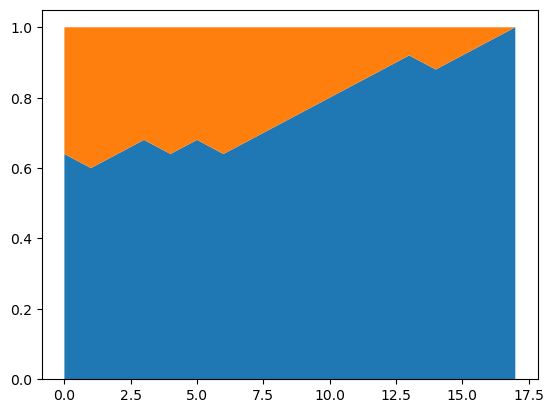

In [5]:
plot_history(population)

Create a new population on a $25 \times 25$ grid with two distinct gene variants.  Run the simulation and return the number of steps.

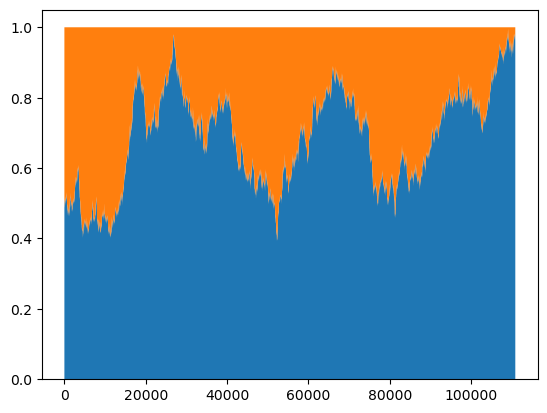

In [6]:
population = Population((25, 25), 2)
population.run()
plot_history(population)

Create a new population on a $5 \times 5$ grid with two distinct gene variants, the first is much more likely than the second.  Run the simulation and plot the distribution of gene variants.

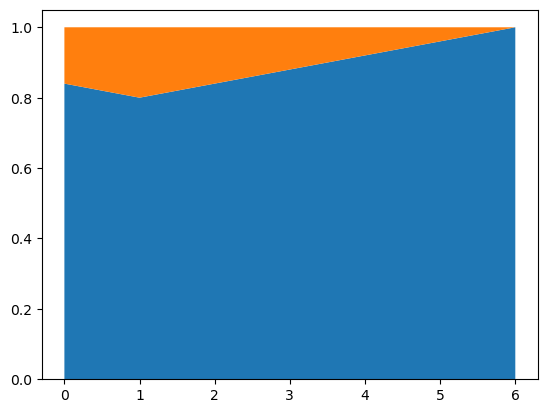

In [7]:
population = Population((5, 5), 2, p=(0.85, 0.15))
population.run()
plot_history(population)

Create a new population on a $5 \times 5 \times 5$ grid with two distinct gene variants.  Run the simulation and plot the evolution of the distribution of gene variants.

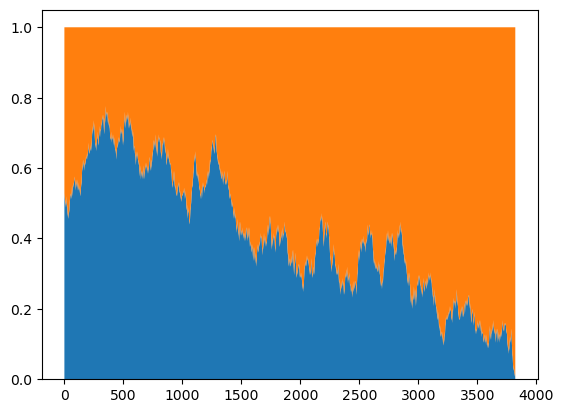

In [8]:
population = Population((5, 5, 5), 2)
population.run()
plot_history(population)

Create a new population on a $10 \times 10$ grid with 5 distinct gene variants.  Run the simulation and plot the distribution of gene variants.

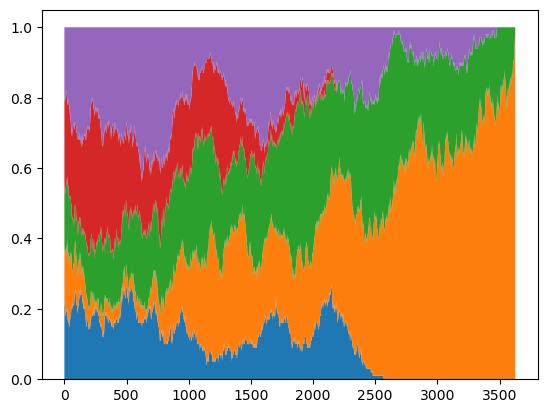

In [9]:
population = Population((10, 10), 5)
population.run()
plot_history(population)

# Scaling

How does the number of steps required to reach equilibrium change as a function of the system size?

In [11]:
data = []
for size in range(10, 51, 10):
    print(f'size = {size}')
    data.append([])
    for i in range(10):
        print(f'\trun {i}')
        population = Population((size, size), 2)
        population.run()
        data[-1].append(population.nr_steps)

size = 10
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
size = 20
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
size = 30
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
size = 40
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
size = 50
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9


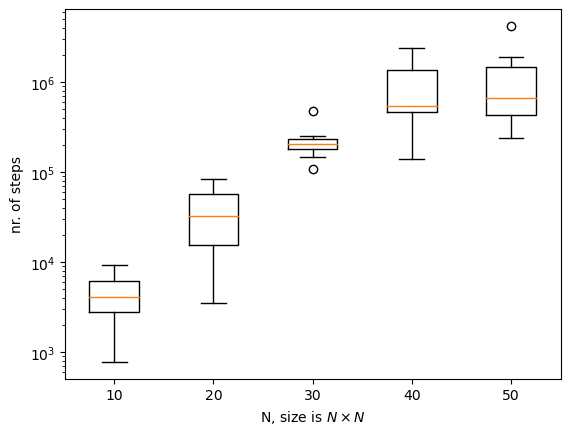

In [24]:
plt.boxplot(data)
plt.xticks(ticks=[1, 2, 3, 4, 5], labels=list(range(10, 51, 10)))
plt.yscale('log')
plt.xlabel(r'N, size is $N \times N$')
plt.ylabel('nr. of steps');

How does the number of steps vary as a function of the number of gene variants in the system?

In [18]:
size = 10
data_variants = []
for nr_variants in range(2, 9):
    print(f'variants = {nr_variants}')
    data_variants.append([])
    for i in range(10):
        print(f'\trun {i}')
        population = Population((size, size), nr_variants)
        population.run()
        data_variants[-1].append(population.nr_steps)

variants = 2
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
variants = 3
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
variants = 4
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
variants = 5
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
variants = 6
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
variants = 7
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
variants = 8
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9


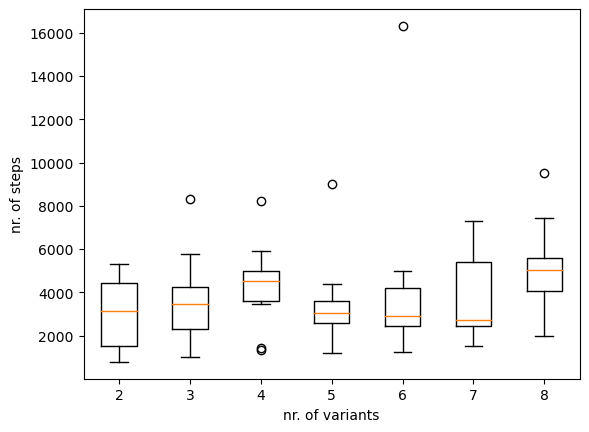

In [22]:
plt.boxplot(data_variants)
plt.xticks(list(range(1, 8)), labels=list(range(2, 9)))
plt.xlabel('nr. of variants')
plt.ylabel('nr. of steps');

How does the number of steps vary as a function of the number of dimensions?

In [25]:
size = 10
nr_variants = 2
data_dims = []
for dims in range(1, 5):
    print(f'dim = {dims}')
    data_dims.append([])
    for i in range(10):
        print(f'\trun {i}')
        population = Population((size,)*dims, nr_variants)
        population.run()
        data_dims[-1].append(population.nr_steps)

dim = 1
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
dim = 2
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
dim = 3
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
dim = 4
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9


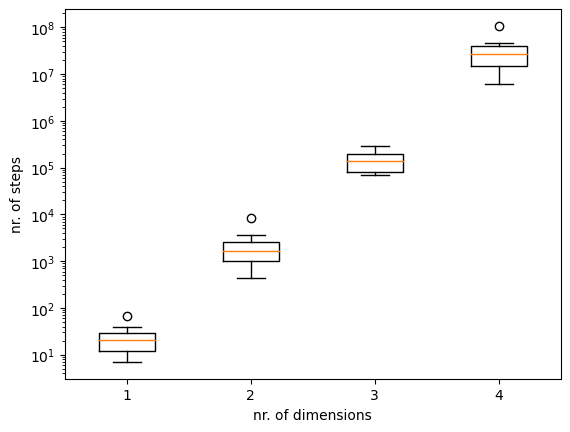

In [38]:
plt.boxplot(data_dims)
plt.yscale('log')
plt.xticks(list(range(1, 5)), labels=list(range(1, 5)))
plt.xlabel('nr. of dimensions')
plt.ylabel('nr. of steps');

In [34]:
shapes = [(2**6, ), (2**3, )*2, (2**2, )*3]
nr_variants = 2
data_dims_same = []
for shape in shapes:
    print(f'dim = {shape}')
    data_dims_same.append([])
    for i in range(10):
        print(f'\trun {i}')
        population = Population(shape, nr_variants)
        population.run()
        data_dims_same[-1].append(population.nr_steps)

dim = (64,)
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
dim = (8, 8)
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9
dim = (4, 4, 4)
	run 0
	run 1
	run 2
	run 3
	run 4
	run 5
	run 6
	run 7
	run 8
	run 9


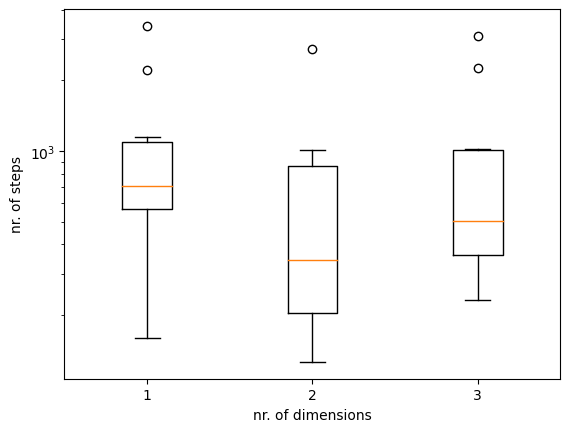

In [37]:
plt.boxplot(data_dims_same)
plt.yscale('log')
plt.xticks(list(range(1, 4)), labels=list(range(1, 4)))
plt.xlabel('nr. of dimensions')
plt.ylabel('nr. of steps');